# **GPU para Digits - Jugando con Circuito cuántico**
*Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Creado por: **Sebastián González Juárez**

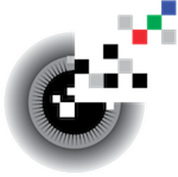
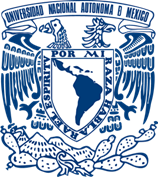

## A) Imports, GPU, dtypes y hparams

In [1]:
import os, math, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pennylane as qml

# Reproducibilidad
SEED = 87
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# *** Fix dtype: trabajar en float32 ***
torch.set_default_dtype(torch.float32)

# Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available(), "| GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("PennyLane:", qml.__version__)
print("BACKEND=torch | diff=backprop | TORCH_DEVICE =", DEVICE)

# Hiperparámetros
EPOCHS   = 20
BATCH    = 64
LR0      = 1e-3
PATIENCE = 3

# Geometría 4x4 -> 16 qubits
W = H = 4
N_WIRES = W*H


Torch: 2.5.1+cu121 | CUDA: True | GPU: NVIDIA GeForce RTX 3090
PennyLane: 0.37.0
BACKEND=torch | diff=backprop | TORCH_DEVICE = cuda


## B) Datos DIGITS → binario (0 vs 1) → avg-pool 2×2 → 4×4

In [2]:
def avg_pool_2x2(img8):
    return img8.reshape(4,2,4,2).mean(axis=(1,3))

def make_binary_digits(c0=0, c1=1, test_size=0.15, val_size=0.15):
    X, y = load_digits(return_X_y=True)
    X = X.reshape(-1,8,8)
    mask = np.isin(y, [c0, c1])
    X = X[mask]; y = y[mask]
    y = (y == c1).astype(np.int64)

    X4 = np.stack([avg_pool_2x2(img) for img in X], axis=0)  # [n,4,4]
    X4 = (X4 - X4.min())/(X4.max()-X4.min()+1e-8)

    X_tr, X_te, y_tr, y_te = train_test_split(X4, y, test_size=test_size, random_state=SEED, stratify=y)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=val_size, random_state=SEED, stratify=y_tr)

    toT = lambda a: torch.tensor(a, dtype=torch.float32)
    ds = {
        "train": (toT(X_tr), torch.tensor(y_tr, dtype=torch.float32)),
        "val":   (toT(X_va), torch.tensor(y_va, dtype=torch.float32)),
        "test":  (toT(X_te), torch.tensor(y_te, dtype=torch.float32)),
    }
    return ds

ds = make_binary_digits(0,1)
for k,(Xk, yk) in ds.items():
    print(k, Xk.shape, yk.shape, "pos=", int((yk==1).sum()), "neg=", int((yk==0).sum()))

class Digits4x4Dataset(Dataset):
    def __init__(self, X, y): self.X=X; self.y=y
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i].flatten(), self.y[i]

loaders = {
    split: DataLoader(Digits4x4Dataset(*pair), batch_size=BATCH, shuffle=(split=="train"), pin_memory=True)
    for split, pair in ds.items()
}


train torch.Size([260, 4, 4]) torch.Size([260]) pos= 132 neg= 128
val torch.Size([46, 4, 4]) torch.Size([46]) pos= 23 neg= 23
test torch.Size([54, 4, 4]) torch.Size([54]) pos= 27 neg= 27


## C) VQA (feature map + ansatz 3 capas) y modelo binario

In [3]:
# Pares vecinos en 4x4
def neighbor_pairs_4x4():
    pairs=[]; idx=lambda r,c: r*W+c
    for r in range(H):
        for c in range(W):
            if r+1<H: pairs.append((idx(r,c), idx(r+1,c)))
            if c+1<W: pairs.append((idx(r,c), idx(r,c+1)))
    return pairs

GRID_PAIRS = neighbor_pairs_4x4()
BRICK_0 = [(r*W+c, r*W+c+1) for r in range(H) for c in range(0, W-1, 2)]
BRICK_1 = [(r*W+c, r*W+c+1) for r in range(H) for c in range(1, W-1, 2)]
BRICKS  = [BRICK_0, BRICK_1]

# Dispositivo en GPU
dev = qml.device("default.qubit.torch", wires=N_WIRES)

class QuantumLayerVQA(nn.Module):
    def __init__(self, n_blocks=3):
        super().__init__()
        self.n_blocks = n_blocks
        # Feature map (entrenable)
        self.alpha = nn.Parameter(torch.ones(N_WIRES))   # escala píxel
        self.beta  = nn.Parameter(torch.zeros(N_WIRES))  # mezcla vecinos
        self.kappa = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))  # acoplo datos

        # Ansatz: RY+RZ por qubit y capa
        self.theta = nn.Parameter(torch.zeros(n_blocks, N_WIRES))
        self.phi   = nn.Parameter(torch.zeros(n_blocks, N_WIRES))

        # Entrelazadores ZZ brick paramétricos
        n_pairs = max(len(p) for p in BRICKS)
        self.eta = nn.Parameter(torch.zeros(n_blocks, len(BRICKS), n_pairs))

        self.qnode = qml.QNode(self._qfunc, dev, interface="torch", diff_method="backprop")

    # --- helpers ---
    def _hadamards(self):
        for w in range(N_WIRES):
            qml.Hadamard(wires=w)

    def _encode_neighbors(self, x):
        for r in range(H):
            for c in range(W):
                i = r*W + c
                neigh=[]
                if r>0:    neigh.append((r-1)*W + c)
                if r+1<H:  neigh.append((r+1)*W + c)
                if c>0:    neigh.append(r*W + (c-1))
                if c+1<W:  neigh.append(r*W + (c+1))
                m = torch.stack([x[j] for j in neigh]).mean() if len(neigh)>0 else torch.tensor(0., device=x.device, dtype=x.dtype)
                angle = self.alpha[i]*x[i] + self.beta[i]*m
                qml.RY(angle, wires=i)
        for (i,j) in GRID_PAIRS:
            qml.IsingXX(self.kappa * (x[i] - x[j]), wires=[i,j])

    def _brick_zz(self, b, layer_id):
        pairs = BRICKS[layer_id % len(BRICKS)]
        for k,(i,j) in enumerate(pairs):
            qml.IsingZZ(self.eta[b, layer_id, k], wires=[i,j])

    # --- circuito ---
    def _qfunc(self, weights, x):
        self._hadamards()
        self._encode_neighbors(x)
        for b in range(self.n_blocks):
            for w in range(N_WIRES):
                qml.RY(weights["theta"][b,w], wires=w)
                qml.RZ(weights["phi"][b,w],   wires=w)
            self._brick_zz(b, 0); self._brick_zz(b, 1)
        return [qml.expval(qml.PauliZ(w)) for w in range(N_WIRES)]

    def forward(self, x_batch):
        outs=[]
        weights = {"theta": self.theta, "phi": self.phi, "eta": self.eta}
        for i in range(x_batch.size(0)):
            res = self.qnode(weights, x_batch[i])                 
            res = [r.to(dtype=x_batch.dtype) for r in res]
            outs.append(torch.stack(res))
        return torch.stack(outs, dim=0)  # [B,16], float32

class QuantumBinaryModel(nn.Module):
    def __init__(self, n_blocks=3):
        super().__init__()
        self.q = QuantumLayerVQA(n_blocks=n_blocks)
        self.head = nn.Sequential(
            nn.LayerNorm(N_WIRES),
            nn.Linear(N_WIRES, 32),
            nn.GELU(),
            nn.Dropout(0.10),
            nn.Linear(32, 1),
        )
    def forward(self, x):
        qf = self.q(x)                     # [B,16] float32
        return self.head(qf).squeeze(1)    # [B]


## D) Entrenamiento con trazas y LR scheduler

In [4]:
model = QuantumBinaryModel(n_blocks=3).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=PATIENCE, verbose=False
)

history = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[], "lr":[]}
trace   = {"theta_norm":[], "phi_norm":[], "eta_norm":[], "alpha_norm":[], "beta_norm":[], "kappa":[]}

def accuracy_from_logits(logits, y_true):
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == y_true).float().mean().item()*100.0

def epoch_pass(loader, train=False):
    model.train() if train else model.eval()
    tot_loss=0.0; tot_acc=0.0; n=0
    for xb_cpu, yb_cpu in loader:
        xb = xb_cpu.view(-1,16).to(DEVICE, non_blocking=True)     # float32
        yb = yb_cpu.to(DEVICE, non_blocking=True).float()         # float32

        if train: optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss   = criterion(logits, yb)
        if train:
            loss.backward()
            optimizer.step()

        bs = xb.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += accuracy_from_logits(logits, yb)*bs
        n        += bs
    return tot_loss/n, tot_acc/n

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = epoch_pass(loaders["train"], train=True)
    va_loss, va_acc = epoch_pass(loaders["val"],   train=False)
    scheduler.step(va_loss)

    with torch.no_grad():
        history["lr"].append(optimizer.param_groups[0]["lr"])
        q = model.q
        trace["theta_norm"].append(q.theta.detach().norm().item())
        trace["phi_norm"].append(q.phi.detach().norm().item())
        trace["eta_norm"].append(q.eta.detach().norm().item())
        trace["alpha_norm"].append(q.alpha.detach().norm().item())
        trace["beta_norm"].append(q.beta.detach().norm().item())
        trace["kappa"].append(q.kappa.detach().item())

    history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
    history["va_loss"].append(va_loss); history["va_acc"].append(va_acc)

    print(f"[ep {ep:02d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:5.1f}% | va_loss={va_loss:.4f} va_acc={va_acc:5.1f}% | lr={history['lr'][-1]:.2e}")


C:\Users\lapic\QML2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[ep 01] tr_loss=0.6582 tr_acc= 69.6% | va_loss=0.6370 va_acc= 87.0% | lr=1.00e-03
[ep 02] tr_loss=0.6348 tr_acc= 80.0% | va_loss=0.6132 va_acc= 87.0% | lr=1.00e-03
[ep 03] tr_loss=0.6050 tr_acc= 86.2% | va_loss=0.5940 va_acc= 89.1% | lr=1.00e-03
[ep 04] tr_loss=0.5875 tr_acc= 84.2% | va_loss=0.5754 va_acc= 89.1% | lr=1.00e-03
[ep 05] tr_loss=0.5640 tr_acc= 87.3% | va_loss=0.5537 va_acc= 89.1% | lr=1.00e-03
[ep 06] tr_loss=0.5437 tr_acc= 88.5% | va_loss=0.5317 va_acc= 87.0% | lr=1.00e-03
[ep 07] tr_loss=0.5185 tr_acc= 91.2% | va_loss=0.5097 va_acc= 87.0% | lr=1.00e-03
[ep 08] tr_loss=0.4952 tr_acc= 88.8% | va_loss=0.4857 va_acc= 89.1% | lr=1.00e-03
[ep 09] tr_loss=0.4663 tr_acc= 88.1% | va_loss=0.4606 va_acc= 87.0% | lr=1.00e-03
[ep 10] tr_loss=0.4389 tr_acc= 91.9% | va_loss=0.4343 va_acc= 91.3% | lr=1.00e-03
[ep 11] tr_loss=0.4068 tr_acc= 91.9% | va_loss=0.4076 va_acc= 89.1% | lr=1.00e-03
[ep 12] tr_loss=0.3814 tr_acc= 92.3% | va_loss=0.3811 va_acc= 89.1% | lr=1.00e-03
[ep 13] tr_loss=

## E) Test y reporte

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_logits=[]; all_y=[]
with torch.no_grad():
    for xb_cpu, yb_cpu in loaders["test"]:
        xb = xb_cpu.view(-1,16).to(DEVICE)
        yb = yb_cpu.to(DEVICE).float()
        all_logits.append(model(xb).cpu()); all_y.append(yb.cpu())

logits = torch.cat(all_logits); y_true = torch.cat(all_y)
y_pred = (torch.sigmoid(logits) >= 0.5).int()
acc = (y_pred == y_true.int()).float().mean().item()*100

cm = confusion_matrix(y_true.numpy(), y_pred.numpy())
print(f"\n[TEST] acc={acc:.2f}%")
print("Matriz de confusión:\n", cm)
print(classification_report(y_true.numpy(), y_pred.numpy(), digits=3))



[TEST] acc=94.44%
Matriz de confusión:
 [[24  3]
 [ 0 27]]
              precision    recall  f1-score   support

         0.0      1.000     0.889     0.941        27
         1.0      0.900     1.000     0.947        27

    accuracy                          0.944        54
   macro avg      0.950     0.944     0.944        54
weighted avg      0.950     0.944     0.944        54



## F) Gráficas: pérdidas, accuracy, LR y parámetros cuánticos

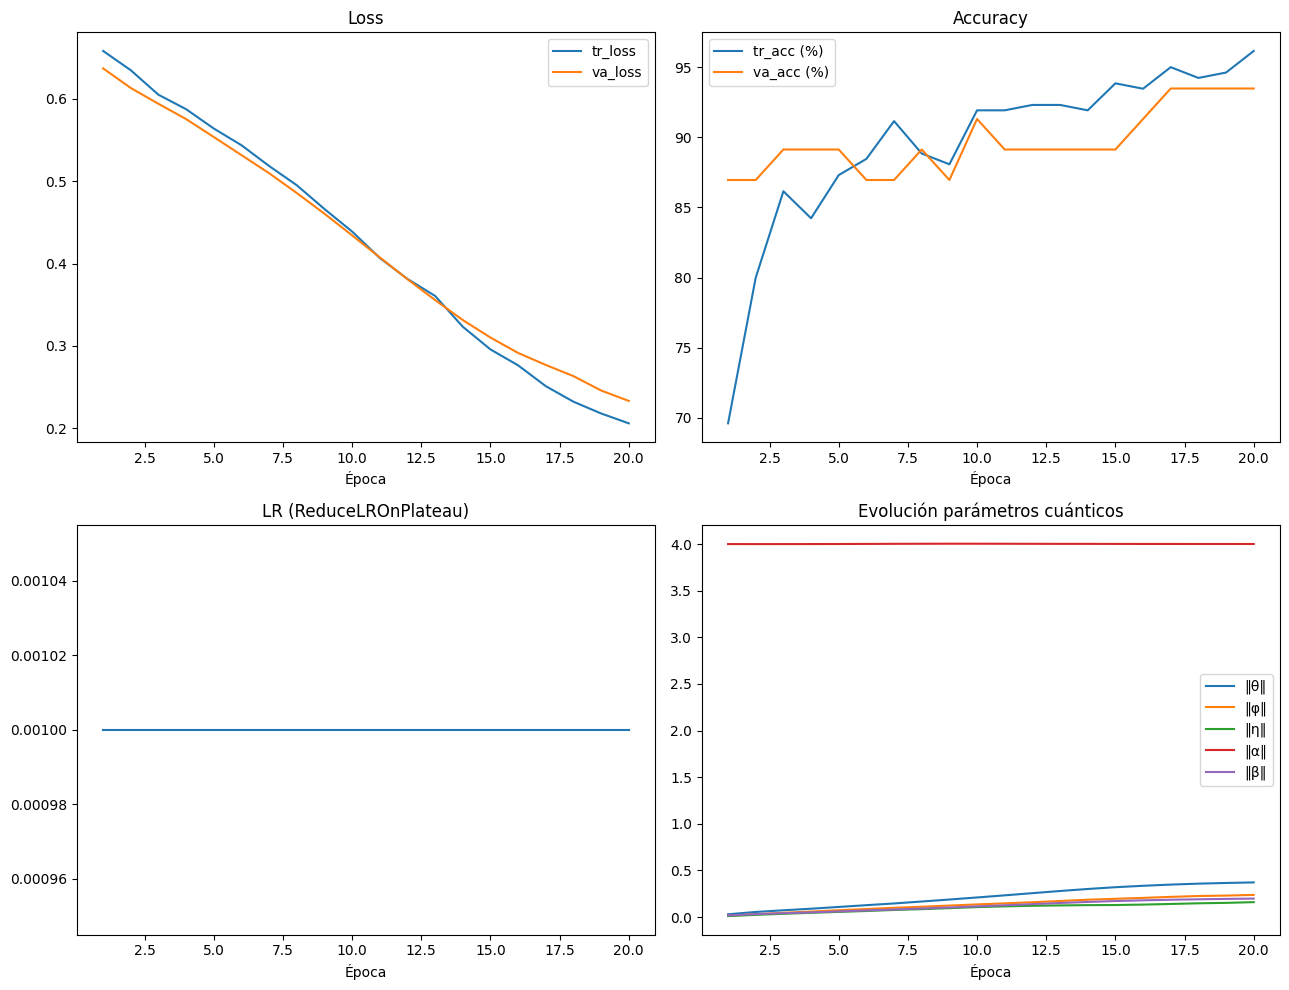

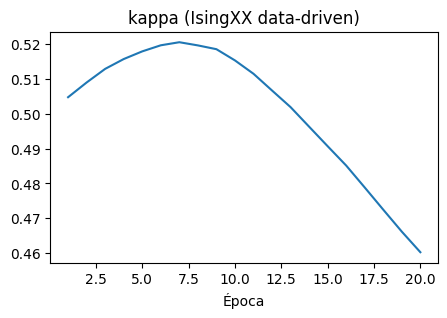

In [6]:
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(13,10))
plt.subplot(2,2,1); plt.plot(epochs, history["tr_loss"], label="tr_loss"); plt.plot(epochs, history["va_loss"], label="va_loss"); plt.title("Loss"); plt.xlabel("Época"); plt.legend()
plt.subplot(2,2,2); plt.plot(epochs, history["tr_acc"], label="tr_acc (%)"); plt.plot(epochs, history["va_acc"], label="va_acc (%)"); plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()
plt.subplot(2,2,3); plt.plot(epochs, history["lr"]); plt.title("LR (ReduceLROnPlateau)"); plt.xlabel("Época")
plt.subplot(2,2,4)
plt.plot(epochs, trace["theta_norm"], label="‖θ‖")
plt.plot(epochs, trace["phi_norm"],   label="‖φ‖")
plt.plot(epochs, trace["eta_norm"],   label="‖η‖")
plt.plot(epochs, trace["alpha_norm"], label="‖α‖")
plt.plot(epochs, trace["beta_norm"],  label="‖β‖")
plt.title("Evolución parámetros cuánticos"); plt.xlabel("Época"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3))
plt.plot(epochs, trace["kappa"])
plt.title("kappa (IsingXX data-driven)"); plt.xlabel("Época")
plt.show()


## G) Dibujo del VQA completo

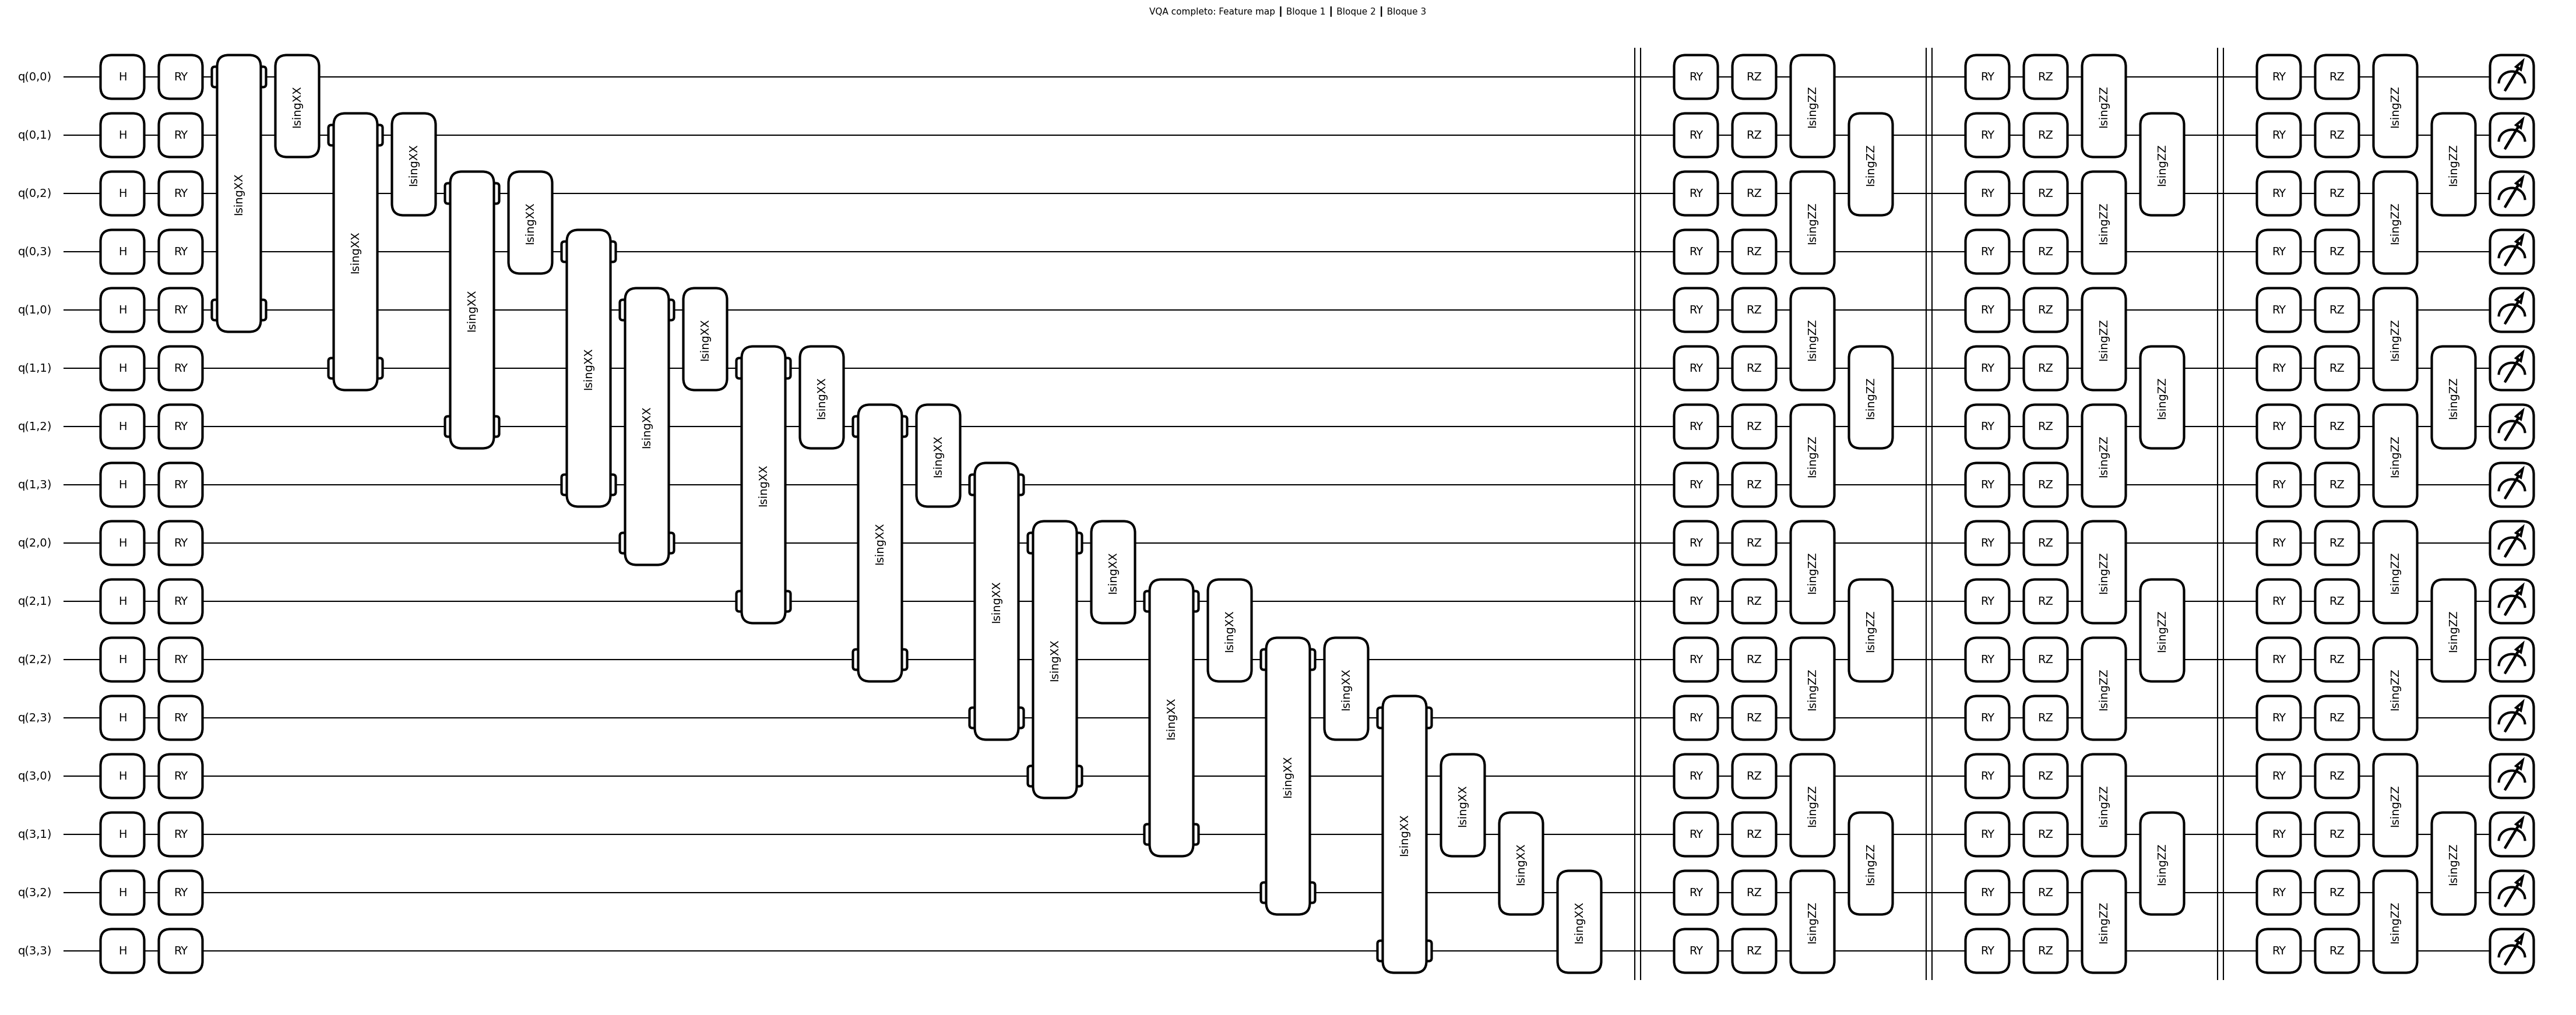

In [7]:
def wire_labels_rc(W=4, H=4):
    return [f"q({r},{c})" for r in range(H) for c in range(W)]

def draw_vqa_full(model, sample_x_4x4=None):
    if sample_x_4x4 is None:
        xb0, _ = next(iter(loaders["val"]))
        sample_x_4x4 = xb0[0].view(4, 4)
    x = sample_x_4x4.flatten().detach().cpu().numpy()

    q = model.q
    alpha = q.alpha.detach().cpu().numpy()
    beta  = q.beta.detach().cpu().numpy()
    kappa = float(q.kappa.detach().cpu().numpy())
    theta = q.theta.detach().cpu().numpy()  # shape: [3, 16]
    phi   = q.phi.detach().cpu().numpy()    # shape: [3, 16]
    eta   = q.eta.detach().cpu().numpy()    # shape: [3, 2, ~n_pairs]

    wires = wire_labels_rc(W, H)
    dev_draw = qml.device("default.qubit", wires=wires)

    def _had():
        for w in wires:
            qml.Hadamard(wires=w)

    def _encode_neighbors(xv):
        for r in range(H):
            for c in range(W):
                i = r * W + c
                neigh = []
                if r > 0:        neigh.append((r - 1) * W + c)
                if r + 1 < H:    neigh.append((r + 1) * W + c)
                if c > 0:        neigh.append(r * W + (c - 1))
                if c + 1 < W:    neigh.append(r * W + (c + 1))
                m = np.mean([xv[j] for j in neigh]) if len(neigh) > 0 else 0.0
                qml.RY(alpha[i] * xv[i] + beta[i] * m, wires=wires[i])

        for (i, j) in GRID_PAIRS:
            qml.IsingXX(kappa * (xv[i] - xv[j]), wires=[wires[i], wires[j]])

    def _brick_zz(b, lid):
        pairs = BRICKS[lid % len(BRICKS)]
        for k, (i, j) in enumerate(pairs):
            qml.IsingZZ(eta[b, lid, k], wires=[wires[i], wires[j]])

    @qml.qnode(dev_draw)
    def circuit_vis():
        # --- FEATURE MAP ---
        _had()
        _encode_neighbors(x)
        qml.Barrier(wires=wires)

        # --- 3 BLOQUES DEL ANSATZ ---
        for b in range(3):
            # RY + RZ por qubit
            for i in range(N_WIRES):
                qml.RY(theta[b, i], wires=wires[i])
                qml.RZ(phi[b, i],   wires=wires[i])

            # ZZ brickwork (dos capas por bloque)
            _brick_zz(b, 0)
            _brick_zz(b, 1)

            # Separador entre bloques del ANSATZ
            if b < 2:
                qml.Barrier(wires=wires)

        return [qml.expval(qml.PauliZ(w)) for w in wires]

    fig, ax = qml.draw_mpl(circuit_vis, show_all_wires=True)()
    ax.set_title("VQA completo: Feature map ┃ Bloque 1 ┃ Bloque 2 ┃ Bloque 3", fontsize=11)
    plt.show()

draw_vqa_full(model)
